 20%|██        | 1/5 [00:00<00:01,  3.10it/s]

max:  tensor(110)


 40%|████      | 2/5 [00:00<00:00,  3.14it/s]

max:  tensor(16)


 60%|██████    | 3/5 [00:00<00:00,  3.17it/s]

max:  tensor(36)


 80%|████████  | 4/5 [00:01<00:00,  3.17it/s]

max:  tensor(97)


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

max:  tensor(0)
tensor(51.8000)


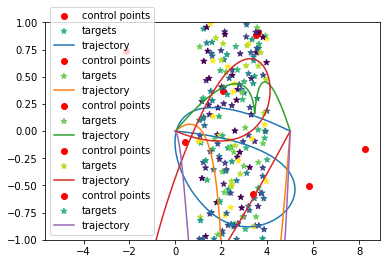

In [12]:
from src import generate_game, N_CTPS, evaluate, compute_traj, RADIUS
from agent_sol import Agent
from tqdm import tqdm # a convenient progress bar
import torch
import matplotlib.pyplot as plt
from src import splev, evaluate

P = 3
N_TARGETS = 20
N_CLASSES = 10
N_EVALS = 5
# To understand what a trajectory looks like,
# let's generate a B-Spline of degree P with N control points from (0,0) to (N_CTPS,0).
# Note that a (clamped) B-Spline passes through its first and last control points.

n_targets = 40
agent = Agent()

data = torch.load("data.pth")
label = data["label"]
feature = data["feature"]

t = torch.linspace(0, N_CTPS-P, 100)
knots = torch.cat([
    torch.zeros(P),
    torch.arange(N_CTPS+1-P),
    torch.full((P,), N_CTPS-P),
])
ctps = torch.zeros(N_CTPS, 2)
ctps[0] = torch.tensor([0., 0.])
ctps[1:-1, 0] = torch.linspace(1, N_CTPS-1, N_CTPS-2)
ctps[1:-1, 1].uniform_(-1, 1)
ctps[-1] = torch.tensor([N_CTPS, 0.])
traj = splev(t, knots, ctps, P)

scores = []
for game in tqdm(range(N_EVALS)):

        # the class information is unavailable at test time.
    target_pos, target_features, target_cls, class_scores = generate_game(n_targets, N_CTPS, feature, label)
    ctps_inter = agent.get_action(target_pos, target_features, class_scores)
    score = evaluate(compute_traj(ctps_inter), target_pos, class_scores[target_cls], RADIUS)
    scores.append(score)

    # %matplotlib inline
    plt.scatter(*ctps_inter.data.T, color="red", label="control points")
    plt.scatter(*target_pos.T, c=target_cls, marker="*", label="targets")
    plt.plot(*compute_traj(ctps_inter).data.T, label="trajectory")
    plt.ylim(-1, 1)
    plt.legend()

print(torch.stack(scores).float().mean())



# # Generate N_TARGETS targets
# # essentially the same as `generate_game` function provided
# class_scores = torch.randint(-N_CLASSES, N_CLASSES, (N_CLASSES,))
# target_pos = torch.rand((N_TARGETS, 2)) * torch.tensor([N_CTPS-2, 2.]) + torch.tensor([1., -1.])
# target_cls = torch.randint(0, N_CLASSES, (N_TARGETS,))
# target_scores = class_scores[target_cls]



# evaluate the trajectory by checking which targets does it hit
# your goal is to choose ctps[1:-1] so that the score is maximized
# score = evaluate(traj, target_pos, target_scores, RADIUS)
# print(score)